motor_UPDRS    8.129282
dtype: float64
Results for a 80/20 train/test split:
Iterations: 0 | Epochs (approx): 0.00 | Time: 0.0006 s

Feature names and their corresponding weights:
age: -0.03135403260601993
sex: -0.14994192193379696
test_time: -0.043241629172628276
total_UPDRS: 7.263103911273393
Jitter(%): 1.8101184345900638
Jitter(Abs): -2.5035609710425484
Shimmer: 0.16488099270975232
NHR: -0.19392260878633605
HNR: -0.020652542179570816
RPDE: -0.16985463278116264
DFA: 0.1857107972058314
PPE: 0.5997956731617683

Results for train set:
MSE: 6.464663763634766
RMSE: 2.542570306527386
R^2: 0.8904282121044919

Results for test set:
MSE: 6.848556552157887
RMSE: 2.6169746945963936
R^2: 0.8689063102004351


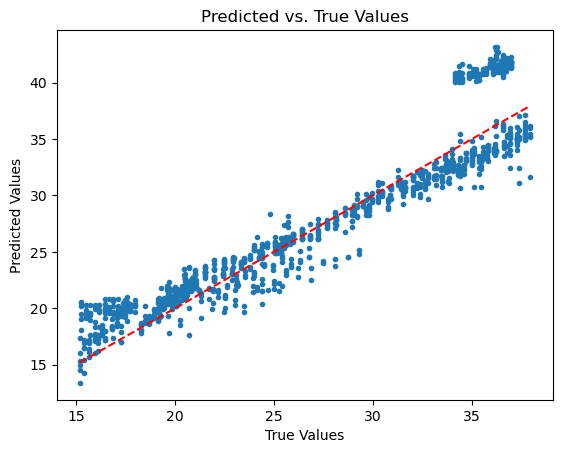

In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import argparse
from scipy import stats
from sklearn.preprocessing import StandardScaler
import time
%matplotlib inline

# Parse Arguments
def check_int(value):
    try:
        ivalue = int(value)
    except ValueError:
        raise argparse.ArgumentTypeError(f"'{value}' is not a valid integer.")

    if ivalue <= 0 or ivalue > 100:
        raise argparse.ArgumentTypeError(f"'{value}' must be an integer between 0 and 100 (exclusive).")

    return ivalue
    
# Create Parser
parser = argparse.ArgumentParser(usage='linear.py [--split|--true] [value]')
# Add Args
parser.add_argument('--split', type=check_int, help='Represents the fraction used as the training set', default=80)
parser.add_argument('--true', action='store_true', help='When set drops total_UPDRS from the features', default=False)
# args = parser.parse_args()
args, _ = parser.parse_known_args()  
if args.split == 100:
    args.split = 99

# Fetch Dataset
df = pd.read_csv("/Users/KkJekz/Desktop/School/COMP 551/parkinsons_updrs.csv")
pd.set_option('display.max_columns', None)

# Data 
X = df.drop(columns=['motor_UPDRS', 'subject#']) 
if (args.true):
    X = X.drop(columns = ['total_UPDRS'])
Y = df[['motor_UPDRS']]
print(Y.std())

# Correlation matrix
corr = abs(X.corr())
# Upper triangular matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
# Find features with correlation greater than 0.9 with each other 
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
# Drop highly correlated features
X = X.drop(to_drop, axis=1)

# Drop outliers with z score greater than 3 
z = np.abs(stats.zscore(X))
# ~0.2% (0.1 above and 0.1 below the mean) of data in a normally distributed dataset will fall in this range
outlier_indices = np.where(z > 3)[0]
X = X.drop(outlier_indices)
Y = Y.drop(outlier_indices)

class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        self.iters_ = 0
        self.epochs_ = 0.0
        self.seconds_ = 0.0
        pass

    def fit(self,x,y):
        if x.ndim == 1:
            x = x[:,None]
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
            start = time.perf_counter()
        self.w = np.linalg.lstsq(x,y, rcond=None)[0]
        self.seconds_ = time.perf_counter() - start
        return self

    def predict(self,x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh

# Split Data
train_range = int(args.split / 100 * len(X))
X_train = X.iloc[:train_range]
X_predict = X.iloc[train_range:]
Y_train = Y.iloc[:train_range]
Y_predict = Y.iloc[train_range:]

# Scale Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_predict = scaler.transform(X_predict)

# Fit and Predict
model = LinearRegression().fit(X_train,Y_train.values)  
yh_train = model.predict(X_train)
yh_test = model.predict(X_predict)

# Cost Function for prediction
mse_test = np.mean((Y_predict.values - yh_test)**2)   
rmse_test = np.sqrt(mse_test)
mse_train = np.mean((Y_train.values - yh_train)**2)
rmse_train = np.sqrt(mse_train)

def R2(y,yh):
    y = y.values
    y_mean = np.mean(y)
    ss_res = np.sum((y-yh)**2)
    ss_tot = np.sum((y-y_mean)**2)
    return 1 - ss_res / ss_tot

print(f'Results for a {args.split}/{100-args.split} train/test split:')
print(f'Iterations: {model.iters_} | Epochs (approx): {model.epochs_:.2f} | Time: {model.seconds_:.4f} s')
print(f'\nFeature names and their corresponding weights:')
for i, col in enumerate(X.columns):
    print(f"{col}: {model.w[i][0]}")
print('\nResults for train set:')
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"R^2: {R2(Y_train, yh_train)}")
print('\nResults for test set:')
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2: {R2(Y_predict, yh_test)}")

# Plot 
y_true_test = Y_predict.values
plt.plot(y_true_test, yh_test, '.')
ymin, ymax = float(y_true_test.min()), float(y_true_test.max())
plt.plot([ymin, ymax],[ymin, ymax], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values')
plt.show()
